In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from torchinfo import summary
from torchviz import make_dot
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from pythonlibs.torch_lib1 import *
import os

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])

In [5]:
data_dir = '../../data/hymenoptera_data'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

print(train_dir, test_dir)

classes = ['ants', 'bees']

../../data/hymenoptera_data/train ../../data/hymenoptera_data/val


In [6]:
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In [7]:
print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 244件
検証データ: 153件


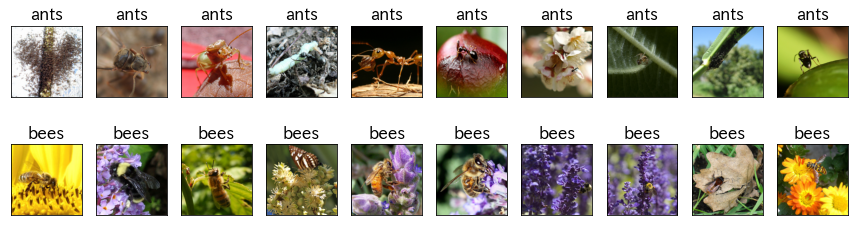

In [8]:
# 検証データ　
# 最初の10個と最後の10個の表示

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [10]:
batch_size = 10

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_data2, batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, batch_size=50, shuffle=True)

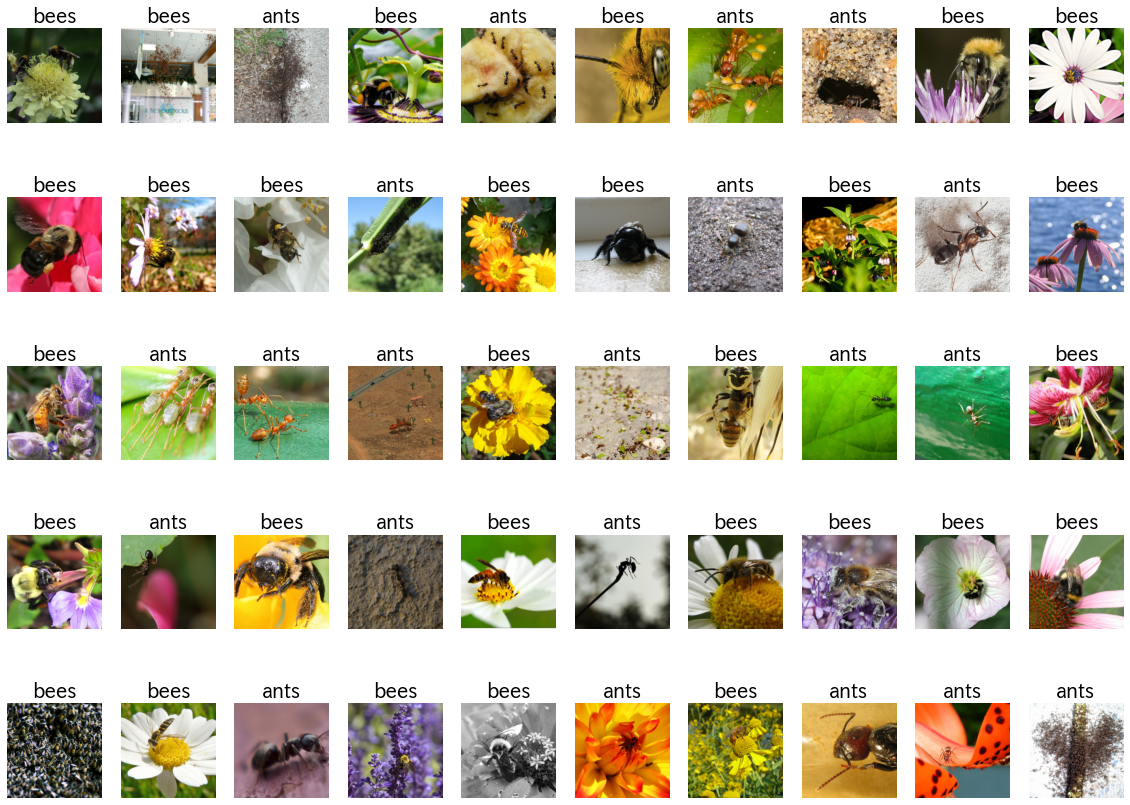

In [11]:
torch_seed()
show_images_labels(test_loader2, classes, None, None)

In [13]:
net = models.vgg19_bn(pretrained=True)

torch_seed()

in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

net.avgpool = nn.Identity()

net = net.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

history = np.zeros((0, 5))

In [14]:
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/5], loss: 0.04343 acc: 0.77459 val_loss: 0.01206, val_acc: 0.96078



Epoch [2/5], loss: 0.02510 acc: 0.89344 val_loss: 0.01117, val_acc: 0.95425



Epoch [3/5], loss: 0.02600 acc: 0.91393 val_loss: 0.00963, val_acc: 0.96732



Epoch [4/5], loss: 0.02822 acc: 0.88934 val_loss: 0.01503, val_acc: 0.93464



Epoch [5/5], loss: 0.02137 acc: 0.92213 val_loss: 0.01559, val_acc: 0.94118


初期状態: 損失: 0.01206 精度: 0.96078
最終状態: 損失: 0.01559 精度: 0.94118


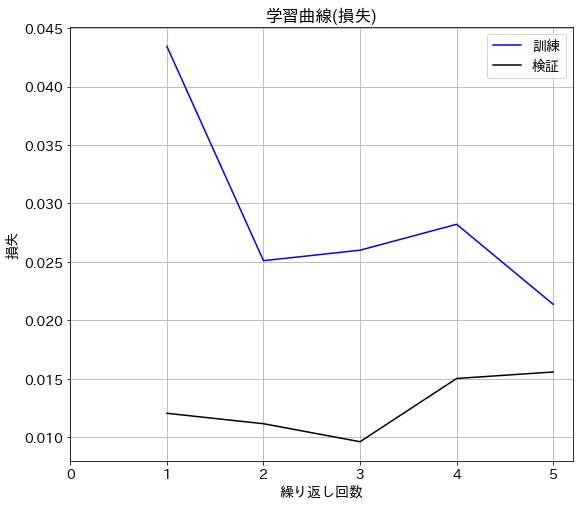

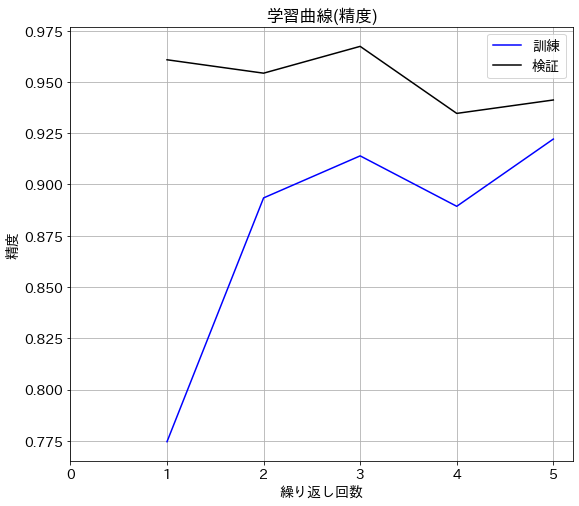

In [15]:
evaluate_history(history)

In [16]:
net = models.vgg19_bn(pretrained=True)

for param in net.parameters():
    param.requires_grad = False

torch_seed()

in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

net.avgpool = nn.Identity()

net = net.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.classifier[6].parameters(), lr=lr, momentum=0.9)

history2 = np.zeros((0, 5))

In [17]:
num_epochs = 5
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)


Epoch [1/5], loss: 0.04569 acc: 0.76230 val_loss: 0.01436, val_acc: 0.96732



Epoch [2/5], loss: 0.02879 acc: 0.88934 val_loss: 0.01204, val_acc: 0.96732



Epoch [3/5], loss: 0.02873 acc: 0.88934 val_loss: 0.01105, val_acc: 0.96078



Epoch [4/5], loss: 0.02975 acc: 0.88525 val_loss: 0.01154, val_acc: 0.96078



Epoch [5/5], loss: 0.02747 acc: 0.88525 val_loss: 0.01115, val_acc: 0.96078


初期状態: 損失: 0.01436 精度: 0.96732
最終状態: 損失: 0.01115 精度: 0.96078


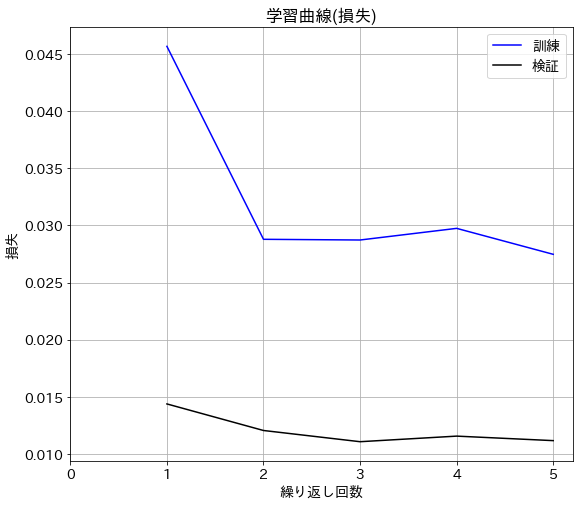

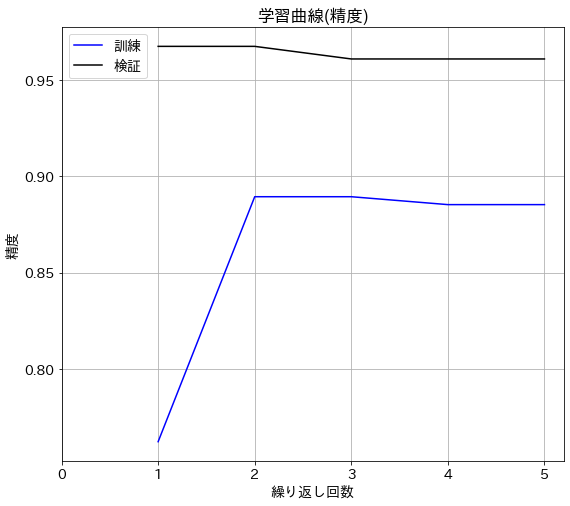

In [18]:
evaluate_history(history2)

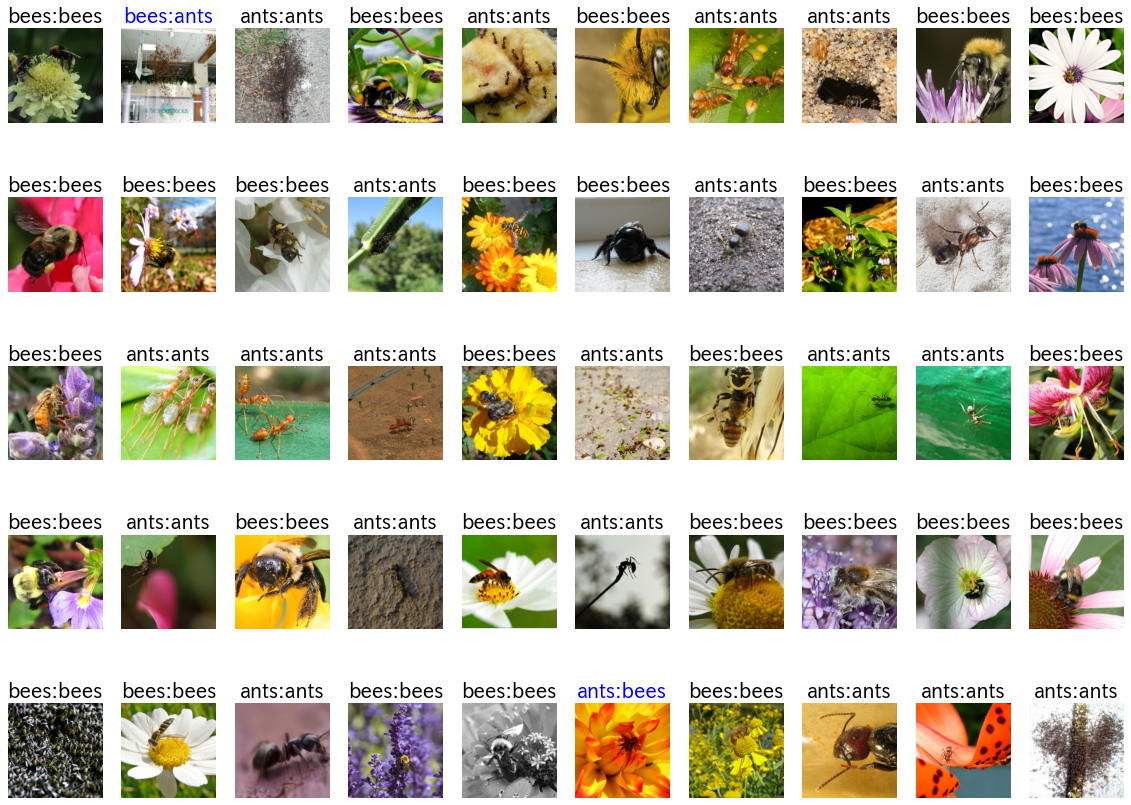

In [19]:
torch_seed()
show_images_labels(test_loader2, classes, net, device)

In [20]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])

In [21]:
data_dir = '../../data/dog_wolf'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

classes = ['dog', 'wolf']

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In [28]:
batch_size = 5

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_data2, batch_size=40, shuffle=False)
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=True)

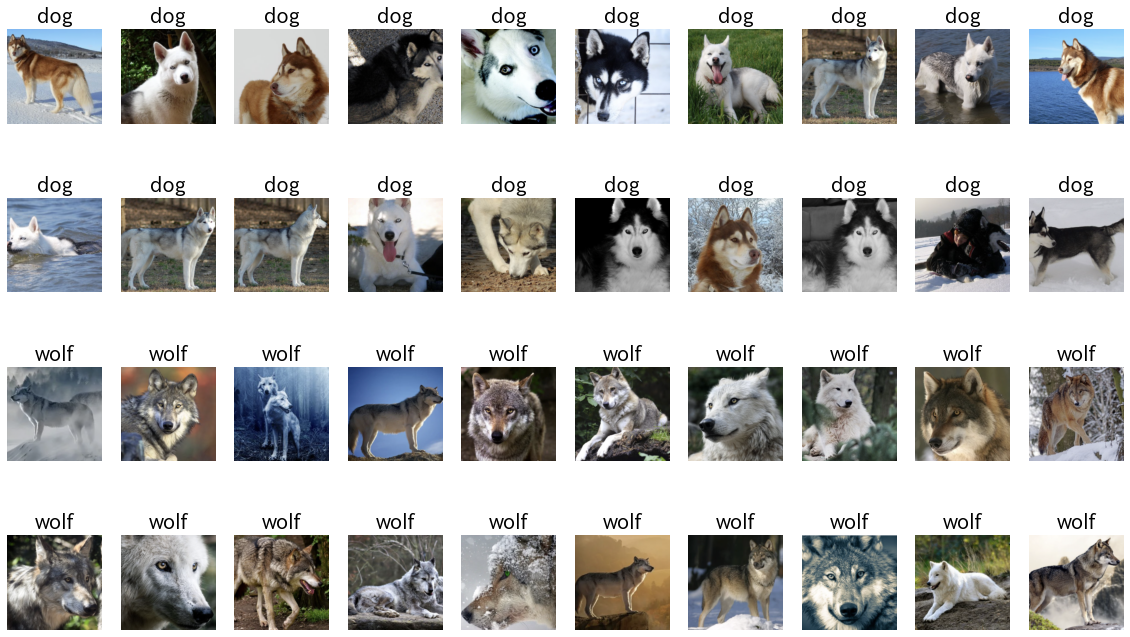

In [23]:
show_images_labels(train_loader2, classes, None, None)

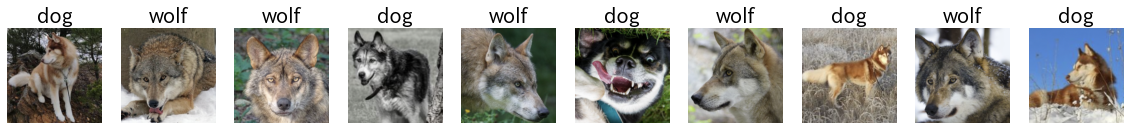

In [24]:
torch_seed()
show_images_labels(test_loader2, classes, None, None)

In [25]:
net = models.vgg19_bn(pretrained=True)

for param in net.parameters():
    param.requires_grad = False

torch_seed()

in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

net.avgpool = nn.Identity()

net = net.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.classifier[6].parameters(), lr=lr, momentum=0.9)

history = np.zeros((0, 5))

In [26]:
num_epochs = 10
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/10], loss: 0.12990 acc: 0.62500 val_loss: 0.08648, val_acc: 0.80000



Epoch [2/10], loss: 0.10071 acc: 0.77500 val_loss: 0.06783, val_acc: 0.90000



Epoch [3/10], loss: 0.04664 acc: 0.92500 val_loss: 0.04059, val_acc: 1.00000



Epoch [4/10], loss: 0.04229 acc: 0.95000 val_loss: 0.03581, val_acc: 1.00000



Epoch [5/10], loss: 0.01070 acc: 1.00000 val_loss: 0.04166, val_acc: 0.90000



Epoch [6/10], loss: 0.02594 acc: 0.95000 val_loss: 0.03627, val_acc: 0.90000



Epoch [7/10], loss: 0.00700 acc: 1.00000 val_loss: 0.04532, val_acc: 0.90000



Epoch [8/10], loss: 0.01120 acc: 1.00000 val_loss: 0.04465, val_acc: 0.90000



Epoch [9/10], loss: 0.04014 acc: 0.95000 val_loss: 0.04481, val_acc: 0.90000



Epoch [10/10], loss: 0.04867 acc: 0.85000 val_loss: 0.06530, val_acc: 0.90000


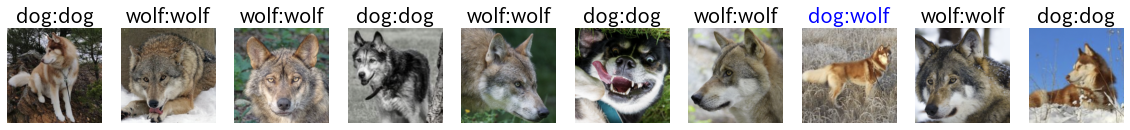

In [32]:
torch_seed()
show_images_labels(test_loader2, classes, net, device)

In [30]:
test_loader2